# DQN Training for Fire-Rescue Environment

#### Deep Q-Network - Value-Based Reinforcement Learning
 
This notebook includes:
 - 10+ hyperparameter configurations
 - Training with different settings
 - Logging and visualization
 - Model saving and evaluation

In [1]:
!pip install gymnasium stable-baselines3 tensorboard matplotlib pandas seaborn tqdm

In [2]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 2: Import Libraries
# ═══════════════════════════════════════════════════════════════════════
import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Stable Baselines
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback, CallbackList
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

# Add project root to path
project_root = Path.cwd().parent if 'training' in str(Path.cwd()) else Path.cwd()
sys.path.insert(0, str(project_root))

# Import custom environment
from environment.custom_env import FireRescueEnv

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)

print("✓ All libraries imported successfully")
print(f"✓ Project root: {project_root}")

✓ All libraries imported successfully
✓ Project root: c:\Users\HP\Programming\ML\fire_rescue_agent


In [3]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 3: Setup Directories
# ═══════════════════════════════════════════════════════════════════════
"""
Create necessary directories for models and logs
"""
# Create directory structure
base_dir = project_root / "models" / "dqn"
logs_dir = base_dir / "training_logs"
tensorboard_dir = base_dir / "tensorboard"
results_dir = project_root / "results"
plots_dir = results_dir / "plots"

for directory in [base_dir, logs_dir, tensorboard_dir, results_dir, plots_dir]:
    directory.mkdir(parents=True, exist_ok=True)

print("✓ Directories created:")
print(f"  - Models: {base_dir}")
print(f"  - Logs: {logs_dir}")
print(f"  - Tensorboard: {tensorboard_dir}")
print(f"  - Results: {results_dir}")

✓ Directories created:
  - Models: c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn
  - Logs: c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\training_logs
  - Tensorboard: c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\tensorboard
  - Results: c:\Users\HP\Programming\ML\fire_rescue_agent\results


In [4]:
# ═══════════════════════════════════════════════════════════════════════
# cell 4: DQN HYPERPARAMETER CONFIGURATIONS
# ═══════════════════════════════════════════════════════════════════════
"""
✅ ENVIRONMENT FIXED - Ready for Retraining!

CRITICAL FIXES APPLIED:
1. ✅ Two-phase distance shaping:
   - Phase 1: Guide TO survivor (+0.2 reward when approaching)
   - Phase 2: Guide TO door with survivor (+0.8 reward when returning)
2. ✅ Removed problematic +5.0 continuous bonus (was making agent camp at door)
3. ✅ Removed confusing invalid pickup bonus
4. ✅ max_time: 200 → 250 steps (more time for learning)

VERIFIED BY TESTS:
✓ Pickup works correctly (+10 reward)
✓ Survivor follows agent when carried
✓ Drop at door triggers success (+50 total reward)
✓ Distance shaping provides +0.79 reward for moving toward door with survivor

TESTING MODE: Only 2 best configs
- config_4_large_batch: Your previous best - stable learning
- config_10_optimized: Recommended - deeper network, balanced params

Expected Results: 40-70% success rate (up from 0%)
"""

DQN_CONFIGS = {
    # ─────────────────────────────────────────────────────────────────────
    # Config 4: LARGE BATCH (More stable but slower) - YOUR PREVIOUS BEST
    # ─────────────────────────────────────────────────────────────────────
    "config_4_large_batch": {
        "learning_rate": 1e-3,
        "gamma": 0.99,
        "batch_size": 128,  # Large batch
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.05,
        "exploration_fraction": 0.2,
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Large Batch - Stable gradients"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 10: OPTIMIZED (Best guess based on task) - RECOMMENDED BEST
    # ─────────────────────────────────────────────────────────────────────
    "config_10_optimized": {
        "learning_rate": 3e-4,  # Sweet spot
        "gamma": 0.99,
        "batch_size": 64,  # Good balance
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.02,
        "exploration_fraction": 0.3,  # Balanced exploration
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[128, 128]),  # Deeper network
        "description": "Optimized - Well-balanced settings"
    },
}

# COMMENTED OUT - Uncomment to train all configs
"""
    # ─────────────────────────────────────────────────────────────────────
    # Config 1: BASELINE (Good starting point)
    # ─────────────────────────────────────────────────────────────────────
    "config_1_baseline": {
        "learning_rate": 1e-3,
        "gamma": 0.99,
        "batch_size": 32,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.05,
        "exploration_fraction": 0.2,
        # Standardized parameters
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Baseline - Standard settings"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 2: HIGH LEARNING RATE (Too aggressive - may not converge)
    # ─────────────────────────────────────────────────────────────────────
    "config_2_high_lr": {
        "learning_rate": 5e-3,  # Very high
        "gamma": 0.99,
        "batch_size": 32,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.05,
        "exploration_fraction": 0.2,
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "High LR - Unstable learning"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 3: LOW LEARNING RATE (Too slow - won't learn much)
    # ─────────────────────────────────────────────────────────────────────
    "config_3_low_lr": {
        "learning_rate": 1e-5,  # Very low
        "gamma": 0.99,
        "batch_size": 32,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.05,
        "exploration_fraction": 0.2,
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Low LR - Slow learning"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 5: SMALL BATCH (Noisier but faster)
    # ─────────────────────────────────────────────────────────────────────
    "config_5_small_batch": {
        "learning_rate": 1e-3,
        "gamma": 0.99,
        "batch_size": 16,  # Small batch
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.05,
        "exploration_fraction": 0.2,
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Small Batch - Fast updates"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 6: LOW GAMMA (Short-sighted - doesn't plan ahead)
    # ─────────────────────────────────────────────────────────────────────
    "config_6_low_gamma": {
        "learning_rate": 1e-3,
        "gamma": 0.95,  # Low discount factor
        "batch_size": 32,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.05,
        "exploration_fraction": 0.2,
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Low Gamma - Myopic policy"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 7: HIGH GAMMA (Very forward-looking)
    # ─────────────────────────────────────────────────────────────────────
    "config_7_high_gamma": {
        "learning_rate": 1e-3,
        "gamma": 0.995,  # High discount factor
        "batch_size": 32,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.05,
        "exploration_fraction": 0.2,
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "High Gamma - Long-term planning"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 8: FAST EXPLORATION DECAY (Stops exploring too soon)
    # ─────────────────────────────────────────────────────────────────────
    "config_8_fast_decay": {
        "learning_rate": 1e-3,
        "gamma": 0.99,
        "batch_size": 32,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.1,  # Higher final epsilon
        "exploration_fraction": 0.1,  # Fast decay
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Fast Decay - Premature exploitation"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 9: SLOW EXPLORATION DECAY (Explores longer)
    # ─────────────────────────────────────────────────────────────────────
    "config_9_slow_decay": {
        "learning_rate": 1e-3,
        "gamma": 0.99,
        "batch_size": 32,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.01,  # Very low final epsilon
        "exploration_fraction": 0.4,  # Slow decay
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Slow Decay - Extended exploration"
    },
    
     # ─────────────────────────────────────────────────────────────────────
    # Config 11: Zero epsilon start and end
    # ─────────────────────────────────────────────────────────────────────
    "config_11_low_gamma": {
        "learning_rate": 1e-3,
        "gamma": 0.95,
        "batch_size": 32,
        "exploration_initial_eps": 0,
        "exploration_final_eps": 0,
        "exploration_fraction": 0.2,
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Zero Epsilon - No exploration"
    }
"""

# ═══════════════════════════════════════════════════════════════════════
# CONFIGURATION SUMMARY TABLE
# ═══════════════════════════════════════════════════════════════════════
print(f"✓ TESTING MODE: Training {len(DQN_CONFIGS)} configurations (2 best configs)")
print(f"✓ To train all 11 configs, uncomment the section above\n")
print("=" * 100)
print(f"{'Config':<25} {'LR':<10} {'Gamma':<8} {'Batch':<8} {'ε_start':<10} {'ε_end':<10} {'ε_decay':<10} {'Network':<15}")
print("=" * 100)

for config_name, config in DQN_CONFIGS.items():
    net_arch = str(config['policy_kwargs']['net_arch'])
    print(f"{config_name:<25} {config['learning_rate']:<10.0e} {config['gamma']:<8.3f} "
          f"{config['batch_size']:<8} {config['exploration_initial_eps']:<10.2f} "
          f"{config['exploration_final_eps']:<10.2f} {config['exploration_fraction']:<10.2f} {net_arch:<15}")

print("=" * 100)
print("\nSelected Configs:")
print("  • config_4_large_batch: Your previous best - stable learning")
print("  • config_10_optimized: Recommended best - deeper network, balanced params")
print("\n🔥 ENVIRONMENT FIXES SUMMARY:")
print("  ✅ Two-phase distance shaping (find survivor → return to door)")
print("  ✅ Removed continuous +5.0 bonus that caused camping at door")
print("  ✅ Proper reward signals: +0.2 to survivor, +0.8 to door when carrying")
print("  ✅ max_time: 250 steps (sufficient for full rescue sequence)")
print("  ✅ All mechanics verified by test suite")
print("=" * 100)

✓ TESTING MODE: Training 2 configurations (2 best configs)
✓ To train all 11 configs, uncomment the section above

Config                    LR         Gamma    Batch    ε_start    ε_end      ε_decay    Network        
config_4_large_batch      1e-03      0.990    128      1.00       0.05       0.20       [64, 64]       
config_10_optimized       3e-04      0.990    64       1.00       0.02       0.30       [128, 128]     

Selected Configs:
  • config_4_large_batch: Your previous best - stable learning
  • config_10_optimized: Recommended best - deeper network, balanced params

🔥 ENVIRONMENT FIXES SUMMARY:
  ✅ Two-phase distance shaping (find survivor → return to door)
  ✅ Removed continuous +5.0 bonus that caused camping at door
  ✅ Proper reward signals: +0.2 to survivor, +0.8 to door when carrying
  ✅ max_time: 250 steps (sufficient for full rescue sequence)
  ✅ All mechanics verified by test suite


## 🔥 CRITICAL BUG FIX - Scan Exploit

**Problem Identified:** The old model had 0% success rate because:
1. **Scan Exploit**: Scanning near survivor gave +0.5 reward
2. When agent **carries** survivor, it's always "near" the survivor  
3. Agent learned to **spam SCAN** instead of moving to door and dropping!

**Fix Applied:**
- ✅ Scan now gives **-0.2 penalty** when carrying survivor
- ✅ Scan only gives +0.5 reward when NOT carrying (for finding survivor)
- ✅ Added +0.5 bonus for being AT survivor location (encourages pickup)
- ✅ Added +1.0 bonus for being AT door while carrying (encourages drop)

**You MUST retrain** - the old model learned the exploit!

In [5]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 5: Training Configuration
# ═══════════════════════════════════════════════════════════════════════
"""
Set training parameters (matching PPO for fair comparison)

IMPORTANT: Environment now uses max_time=250 (updated from 200)
"""
# Training settings
TOTAL_TIMESTEPS = 100000  # Match PPO training timesteps
EVAL_FREQ = 5000          # Evaluate every N steps
N_EVAL_EPISODES = 10      # Number of episodes for evaluation
SAVE_FREQ = 10000         # Save model checkpoint every N steps

print("Training Configuration:")
print(f"  - Total Timesteps: {TOTAL_TIMESTEPS:,}")
print(f"  - Evaluation Frequency: {EVAL_FREQ:,}")
print(f"  - Evaluation Episodes: {N_EVAL_EPISODES}")
print(f"  - Checkpoint Frequency: {SAVE_FREQ:,}")
print(f"  - Environment max_time: 250 steps (updated from 200)")
print(f"\nNote: Timesteps match PPO training for fair comparison")

Training Configuration:
  - Total Timesteps: 100,000
  - Evaluation Frequency: 5,000
  - Evaluation Episodes: 10
  - Checkpoint Frequency: 10,000
  - Environment max_time: 250 steps (updated from 200)

Note: Timesteps match PPO training for fair comparison


In [6]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 6: Training Function
# ═══════════════════════════════════════════════════════════════════════
"""
Function to train a single DQN configuration
UPDATED: Uses max_time=250 for all environments
"""

def train_dqn_config(config_name, config, total_timesteps=TOTAL_TIMESTEPS):
    """
    Train DQN with given configuration
    
    Args:
        config_name: Name of the configuration
        config: Dictionary of hyperparameters
        total_timesteps: Total training steps
    
    Returns:
        Dictionary with training results
    """
    print(f"\n{'='*70}")
    print(f"Training: {config_name}")
    print(f"Description: {config['description']}")
    print(f"{'='*70}")
    
    # Create environment with UPDATED max_time=250
    env = FireRescueEnv(grid_size=10, max_time=250)  # UPDATED from 200
    env = Monitor(env)
    
    # Create eval environment
    eval_env = FireRescueEnv(grid_size=10, max_time=250)  # UPDATED from 200
    eval_env = Monitor(eval_env)
    
    # Create model directory for this config
    model_dir = base_dir / config_name
    model_dir.mkdir(exist_ok=True)
    
    # Setup callbacks
    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=str(model_dir),
        log_path=str(logs_dir / config_name),
        eval_freq=EVAL_FREQ,
        n_eval_episodes=N_EVAL_EPISODES,
        deterministic=True,
        render=False,
        verbose=1
    )
    
    checkpoint_callback = CheckpointCallback(
        save_freq=SAVE_FREQ,
        save_path=str(model_dir / "checkpoints"),
        name_prefix="dqn_checkpoint",
        save_replay_buffer=True,
        save_vecnormalize=True
    )
    
    callback_list = CallbackList([eval_callback, checkpoint_callback])
    
    # Extract hyperparameters (remove description)
    train_config = {k: v for k, v in config.items() if k != 'description'}
    
    # Create DQN model
    model = DQN(
        "MlpPolicy",
        env,
        verbose=1,
        seed=SEED,
        tensorboard_log=str(tensorboard_dir / config_name),
        **train_config
    )
    
    # Train
    start_time = datetime.now()
    print(f"\nStarting training at {start_time.strftime('%H:%M:%S')}")
    
    try:
        model.learn(
            total_timesteps=total_timesteps,
            callback=callback_list,
            progress_bar=True
        )
        
        training_time = (datetime.now() - start_time).total_seconds()
        print(f"\n✓ Training completed in {training_time:.1f} seconds")
        
        # Save final model
        final_model_path = model_dir / "final_model"
        model.save(str(final_model_path))
        print(f"✓ Model saved to {final_model_path}")
        
        # Final evaluation (100 episodes to match PPO)
        print("\nFinal evaluation (100 episodes)...")
        mean_reward, std_reward = evaluate_policy(
            model, 
            eval_env, 
            n_eval_episodes=100,
            deterministic=True
        )
        
        # ═══════════════════════════════════════════════════════════════════════
        # Calculate episode metrics (matching PPO)
        # ═══════════════════════════════════════════════════════════════════════
        print(f"Calculating episode performance metrics...")
        episode_rewards = []
        episode_lengths = []
        wall_collision_rates = []
        scan_efficiencies = []
        pickup_attempts_list = []
        time_to_find_survivor_list = []
        success_count = 0  # Track successes
        
        for episode_num in range(100):
            obs, _ = eval_env.reset()
            done = False
            
            while not done:
                action, _states = model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = eval_env.step(action)
                done = terminated or truncated
            
            # Extract metrics from final info
            episode_rewards.append(info.get('episode_length', 0) * -0.01)  # Approximation
            episode_lengths.append(info.get('episode_length', 0))
            wall_collision_rates.append(info.get('wall_collision_rate', 0))
            scan_efficiencies.append(info.get('scan_efficiency', 0))
            pickup_attempts_list.append(info.get('pickup_attempts', 0))
            
            # Track success
            if info.get('success', False):
                success_count += 1
            
            time_found = info.get('time_to_find_survivor', None)
            if time_found is not None:
                time_to_find_survivor_list.append(time_found)
            
            # Debug output for first 5 episodes
            if episode_num < 5:
                success_str = "✓ SUCCESS" if info.get('success', False) else "✗ Failed"
                print(f"  Episode {episode_num+1}: {success_str} | "
                      f"Steps: {info.get('episode_length', 0)} | "
                      f"Wall Collisions: {info.get('wall_collision_rate', 0):.2%} | "
                      f"Scan Eff: {info.get('scan_efficiency', 0):.2%}")
        
        success_rate = success_count / 100
        print(f"\n📊 Evaluation Summary:")
        print(f"   🎯 SUCCESS RATE: {success_rate:.1%} ({success_count}/100)")
        print(f"   Average Episode Length: {np.mean(episode_lengths):.1f} steps")
        print(f"   Wall Collision Rate: {np.mean(wall_collision_rates):.2%}")
        print(f"   Scan Efficiency: {np.mean(scan_efficiencies):.2%}")
        print(f"   Avg Pickup Attempts: {np.mean(pickup_attempts_list):.2f}")
        if time_to_find_survivor_list:
            print(f"   Avg Time to Find Survivor: {np.mean(time_to_find_survivor_list):.1f} steps ({len(time_to_find_survivor_list)}/100 found)")
        
        # Store results (matching PPO format)
        results = {
            'config_name': config_name,
            'description': config['description'],
            'mean_reward': mean_reward,
            'std_reward': std_reward,
            'success_rate': success_rate,  # NEW: Track success rate
            'success_count': success_count,  # NEW: Track success count
            'avg_episode_length': np.mean(episode_lengths),
            'wall_collision_rate': np.mean(wall_collision_rates),
            'scan_efficiency': np.mean(scan_efficiencies),
            'avg_pickup_attempts': np.mean(pickup_attempts_list),
            'avg_time_to_find_survivor': float(np.mean(time_to_find_survivor_list)) if time_to_find_survivor_list else None,
            'survivor_found_count': len(time_to_find_survivor_list),
            'training_time': training_time,
            'total_timesteps': total_timesteps,
            'hyperparameters': train_config
        }
        
        # Save results to JSON
        results_file = model_dir / "results.json"
        with open(results_file, 'w') as f:
            json_results = {
                'config_name': config_name,
                'description': config['description'],
                'mean_reward': float(mean_reward),
                'std_reward': float(std_reward),
                'success_rate': float(success_rate),  # NEW
                'success_count': success_count,  # NEW
                'avg_episode_length': float(np.mean(episode_lengths)),
                'wall_collision_rate': float(np.mean(wall_collision_rates)),
                'scan_efficiency': float(np.mean(scan_efficiencies)),
                'avg_pickup_attempts': float(np.mean(pickup_attempts_list)),
                'avg_time_to_find_survivor': float(np.mean(time_to_find_survivor_list)) if time_to_find_survivor_list else None,
                'survivor_found_count': len(time_to_find_survivor_list),
                'training_time': float(training_time),
                'total_timesteps': total_timesteps,
                'hyperparameters': {
                    k: (float(v) if isinstance(v, (np.floating, np.integer)) else v)
                    for k, v in train_config.items() if k != 'policy_kwargs'
                }
            }
            json.dump(json_results, f, indent=4)
        
        print(f"✓ Results saved to {results_file}")
        
        # Cleanup
        env.close()
        eval_env.close()
        
        return results
        
    except Exception as e:
        print(f"\n✗ Training failed: {e}")
        env.close()
        eval_env.close()
        return None

print("✓ Training function defined")

✓ Training function defined


In [7]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 7: Train All Configurations
# ═══════════════════════════════════════════════════════════════════════
"""
Train all DQN configurations
WARNING: This will take several hours!
"""

# Store all results
all_results = []

print(f"\n{'#'*70}")
print(f"STARTING FULL TRAINING RUN")
print(f"Training {len(DQN_CONFIGS)} configurations")
print(f"Estimated time: {len(DQN_CONFIGS) * 15} - {len(DQN_CONFIGS) * 30} minutes")
print(f"{'#'*70}\n")

# Train each configuration
for config_name, config in DQN_CONFIGS.items():
    results = train_dqn_config(config_name, config)
    
    if results:
        all_results.append(results)
        print(f"\n✓ Completed {len(all_results)}/{len(DQN_CONFIGS)} configurations")
    else:
        print(f"\n✗ Failed configuration: {config_name}")
    
    print(f"\n{'='*70}\n")

print(f"\n{'#'*70}")
print(f"TRAINING COMPLETE!")
print(f"Successfully trained: {len(all_results)}/{len(DQN_CONFIGS)} configurations")
print(f"{'#'*70}")


######################################################################
STARTING FULL TRAINING RUN
Training 2 configurations
Estimated time: 30 - 60 minutes
######################################################################


Training: config_4_large_batch
Description: Large Batch - Stable gradients
Using cpu device
Wrapping the env in a DummyVecEnv.

Starting training at 16:57:00
Logging to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\tensorboard\config_4_large_batch\DQN_7

Starting training at 16:57:00
Logging to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\tensorboard\config_4_large_batch\DQN_7
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | -78      |
|    exploration_rate | 0.952    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3389     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1000     |
-------------------

Eval num_timesteps=5000, episode_reward=23.85 +/- 47.21

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 23.9     |
| rollout/            |          |
|    exploration_rate | 0.763    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0318   |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 231      |
|    ep_rew_mean      | -40.8    |
|    exploration_rate | 0.736    |
| time/               |          |
|    episodes         | 24       |
|    fps              | 542      |
|    time_elapsed     | 10       |
|    total_timesteps  | 5550     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.171    |
|    n_updates        | 1137     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 233      |
|    ep_rew_mean      | -32.5    |
|    exploration_rate | 0.69     |
| time/               |          |
|    episodes         | 28       |
|    fps              | 542      |
|    time_elapsed     | 12       |
|    total_timesteps  | 6520     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0194   |
|    n_updates      

Eval num_timesteps=10000, episode_reward=25.76 +/- 80.11

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 25.8     |
| rollout/            |          |
|    exploration_rate | 0.525    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0263   |
|    n_updates        | 2249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 219      |
|    ep_rew_mean      | -6.65    |
|    exploration_rate | 0.5      |
| time/               |          |
|    episodes         | 48       |
|    fps              | 541      |
|    time_elapsed     | 19       |
|    total_timesteps  | 10524    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.631    |
|    n_updates        | 2380     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 220      |
|    ep_rew_mean      | -5.13    |
|    exploration_rate | 0.457    |
| time/               |          |
|    episodes         | 52       |
|    fps              | 550      |
|    time_elapsed     | 20       |
|    total_timesteps  | 11433    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0226   |
|    n_updates      

Eval num_timesteps=15000, episode_reward=67.48 +/- 55.89

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 67.5     |
| rollout/            |          |
|    exploration_rate | 0.288    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0179   |
|    n_updates        | 3499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 202      |
|    ep_rew_mean      | 21.4     |
|    exploration_rate | 0.27     |
| time/               |          |
|    episodes         | 76       |
|    fps              | 536      |
|    time_elapsed     | 28       |
|    total_timesteps  | 15360    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.849    |
|    n_updates        | 3589     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 197      |
|    ep_rew_mean      | 24.9     |
|    exploration_rate | 0.25     |
| time/               |          |
|    episodes         | 80       |
|    fps              | 540      |
|    time_elapsed     | 29       |
|    total_timesteps  | 15792    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0182   |
|    n_updates      

Eval num_timesteps=20000, episode_reward=54.88 +/- 55.76

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 54.9     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0207   |
|    n_updates        | 4749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 181      |
|    ep_rew_mean      | 51.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 108      |
|    fps              | 545      |
|    time_elapsed     | 36       |
|    total_timesteps  | 20066    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.01     |
|    n_updates        | 4766     |
----------------------------------
--------------------

Eval num_timesteps=25000, episode_reward=62.56 +/- 58.54

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 62.6     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.352    |
|    n_updates        | 5999     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 159      |
|    ep_rew_mean      | 80.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 144      |
|    fps              | 536      |
|    time_elapsed     | 47       |
|    total_timesteps  | 25523    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.402    |
|    n_updates        | 6130     |
----------------------------------
--------------------

Eval num_timesteps=30000, episode_reward=100.02 +/- 71.01

Episode length: 242.60 +/- 14.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 243      |
|    mean_reward      | 100      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.278    |
|    n_updates        | 7249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 148      |
|    ep_rew_mean      | 92.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 176      |
|    fps              | 536      |
|    time_elapsed     | 56       |
|    total_timesteps  | 30179    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.61     |
|    n_updates        | 7294     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 151      |
|    ep_rew_mean      | 91       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 180      |
|    fps              | 538      |
|    time_elapsed     | 57       |
|    total_timesteps  | 30893    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.468    |
|    n_updates      

Eval num_timesteps=35000, episode_reward=6.97 +/- 137.40

Episode length: 227.20 +/- 68.40

----------------------------------
| eval/               |          |
|    mean_ep_length   | 227      |
|    mean_reward      | 6.97     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.373    |
|    n_updates        | 8499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 148      |
|    ep_rew_mean      | 96.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 212      |
|    fps              | 539      |
|    time_elapsed     | 66       |
|    total_timesteps  | 35647    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.247    |
|    n_updates        | 8661     |
----------------------------------
--------------------

Eval num_timesteps=40000, episode_reward=83.80 +/- 52.30

Episode length: 186.20 +/- 99.34

----------------------------------
| eval/               |          |
|    mean_ep_length   | 186      |
|    mean_reward      | 83.8     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0968   |
|    n_updates        | 9749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 137      |
|    ep_rew_mean      | 108      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 252      |
|    fps              | 545      |
|    time_elapsed     | 74       |
|    total_timesteps  | 40478    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.443    |
|    n_updates        | 9869     |
----------------------------------
--------------------

Eval num_timesteps=45000, episode_reward=110.46 +/- 28.84

Episode length: 175.70 +/- 102.11

----------------------------------
| eval/               |          |
|    mean_ep_length   | 176      |
|    mean_reward      | 110      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.687    |
|    n_updates        | 10999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 137      |
|    ep_rew_mean      | 107      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 284      |
|    fps              | 548      |
|    time_elapsed     | 82       |
|    total_timesteps  | 45144    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.268    |
|    n_updates        | 11035    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 136      |
|    ep_rew_mean      | 107      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 288      |
|    fps              | 548      |
|    time_elapsed     | 82       |
|    total_timesteps  | 45480    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.468    |
|    n_updates      

Eval num_timesteps=50000, episode_reward=78.29 +/- 51.88

Episode length: 226.40 +/- 70.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 226      |
|    mean_reward      | 78.3     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.604    |
|    n_updates        | 12249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 121      |
|    ep_rew_mean      | 101      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 332      |
|    fps              | 549      |
|    time_elapsed     | 91       |
|    total_timesteps  | 50374    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.898    |
|    n_updates        | 12343    |
----------------------------------
--------------------

Eval num_timesteps=55000, episode_reward=-60.33 +/- 141.10

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -60.3    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.27     |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 146      |
|    ep_rew_mean      | 56.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 356      |
|    fps              | 547      |
|    time_elapsed     | 102      |
|    total_timesteps  | 55917    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.609    |
|    n_updates        | 13729    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=-0.94 +/- 91.80

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -0.94    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.378    |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 168      |
|    ep_rew_mean      | 10.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 376      |
|    fps              | 546      |
|    time_elapsed     | 111      |
|    total_timesteps  | 60744    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.842    |
|    n_updates        | 14935    |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=-43.59 +/- 137.53

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -43.6    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0495   |
|    n_updates        | 15999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 182      |
|    ep_rew_mean      | -16.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 408      |
|    fps              | 540      |
|    time_elapsed     | 121      |
|    total_timesteps  | 65528    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.542    |
|    n_updates        | 16131    |
----------------------------------
--------------------

Eval num_timesteps=70000, episode_reward=-103.15 +/- 98.83

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -103     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.144    |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 189      |
|    ep_rew_mean      | -33.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 440      |
|    fps              | 536      |
|    time_elapsed     | 131      |
|    total_timesteps  | 70817    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0992   |
|    n_updates        | 17454    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=51.51 +/- 82.39

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 51.5     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.146    |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 175      |
|    ep_rew_mean      | 11.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 464      |
|    fps              | 517      |
|    time_elapsed     | 145      |
|    total_timesteps  | 75383    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0805   |
|    n_updates        | 18595    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=36.14 +/- 93.75

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 36.1     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.124    |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 178      |
|    ep_rew_mean      | 24.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 488      |
|    fps              | 519      |
|    time_elapsed     | 154      |
|    total_timesteps  | 80215    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.504    |
|    n_updates        | 19803    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=80.85 +/- 40.64

Episode length: 63.20 +/- 93.70

----------------------------------
| eval/               |          |
|    mean_ep_length   | 63.2     |
|    mean_reward      | 80.8     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.212    |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 110      |
|    ep_rew_mean      | 66.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 556      |
|    fps              | 522      |
|    time_elapsed     | 162      |
|    total_timesteps  | 85001    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.246    |
|    n_updates        | 21000    |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=103.85 +/- 47.58

Episode length: 87.50 +/- 104.70

----------------------------------
| eval/               |          |
|    mean_ep_length   | 87.5     |
|    mean_reward      | 104      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.564    |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 75.1     |
|    ep_rew_mean      | 89.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 624      |
|    fps              | 525      |
|    time_elapsed     | 171      |
|    total_timesteps  | 90191    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.562    |
|    n_updates        | 22297    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=79.01 +/- 42.45

Episode length: 67.60 +/- 91.32

----------------------------------
| eval/               |          |
|    mean_ep_length   | 67.6     |
|    mean_reward      | 79       |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.897    |
|    n_updates        | 23499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.3     |
|    ep_rew_mean      | 91.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 732      |
|    fps              | 526      |
|    time_elapsed     | 181      |
|    total_timesteps  | 95294    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.703    |
|    n_updates        | 23573    |
----------------------------------
--------------------

Eval num_timesteps=100000, episode_reward=92.80 +/- 31.14

Episode length: 43.60 +/- 69.13

----------------------------------
| eval/               |          |
|    mean_ep_length   | 43.6     |
|    mean_reward      | 92.8     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0684   |
|    n_updates        | 24749    |
----------------------------------



✓ Training completed in 188.7 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_4_large_batch\final_model

Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: ✓ SUCCESS | Steps: 24 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: ✓ SUCCESS | Steps: 18 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: ✓ SUCCESS | Steps: 10 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: ✓ SUCCESS | Steps: 12 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
Calculating episode performance metrics...
  Episode 1: ✓ SUCCESS | Steps: 24 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: ✓ SUCCESS | Steps: 18 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: ✓ SUCCESS | Steps: 10 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: ✓ SUCCESS | Steps: 12 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: ✗ Failed | Steps: 

Eval num_timesteps=5000, episode_reward=-12.17 +/- 58.58

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | -12.2    |
| rollout/            |          |
|    exploration_rate | 0.837    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0186   |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 236      |
|    ep_rew_mean      | -51.7    |
|    exploration_rate | 0.815    |
| time/               |          |
|    episodes         | 24       |
|    fps              | 647      |
|    time_elapsed     | 8        |
|    total_timesteps  | 5674     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.183    |
|    n_updates        | 1168     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 225      |
|    ep_rew_mean      | -37.9    |
|    exploration_rate | 0.794    |
| time/               |          |
|    episodes         | 28       |
|    fps              | 648      |
|    time_elapsed     | 9        |
|    total_timesteps  | 6311     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0393   |
|    n_updates      

Eval num_timesteps=10000, episode_reward=21.17 +/- 45.38

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 21.2     |
| rollout/            |          |
|    exploration_rate | 0.673    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0173   |
|    n_updates        | 2249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 219      |
|    ep_rew_mean      | -19.2    |
|    exploration_rate | 0.656    |
| time/               |          |
|    episodes         | 48       |
|    fps              | 577      |
|    time_elapsed     | 18       |
|    total_timesteps  | 10519    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0322   |
|    n_updates        | 2379     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 213      |
|    ep_rew_mean      | -11      |
|    exploration_rate | 0.639    |
| time/               |          |
|    episodes         | 52       |
|    fps              | 576      |
|    time_elapsed     | 19       |
|    total_timesteps  | 11065    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.278    |
|    n_updates      

Eval num_timesteps=15000, episode_reward=18.63 +/- 44.84

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 18.6     |
| rollout/            |          |
|    exploration_rate | 0.51     |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0211   |
|    n_updates        | 3499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 208      |
|    ep_rew_mean      | -2.37    |
|    exploration_rate | 0.484    |
| time/               |          |
|    episodes         | 76       |
|    fps              | 567      |
|    time_elapsed     | 27       |
|    total_timesteps  | 15781    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.17     |
|    n_updates        | 3695     |
----------------------------------
--------------------

Eval num_timesteps=20000, episode_reward=9.82 +/- 51.53

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 9.82     |
| rollout/            |          |
|    exploration_rate | 0.347    |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0351   |
|    n_updates        | 4749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 195      |
|    ep_rew_mean      | 18.4     |
|    exploration_rate | 0.329    |
| time/               |          |
|    episodes         | 104      |
|    fps              | 557      |
|    time_elapsed     | 36       |
|    total_timesteps  | 20545    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.173    |
|    n_updates        | 4886     |
----------------------------------
--------------------

Eval num_timesteps=25000, episode_reward=60.95 +/- 55.28

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 61       |
| rollout/            |          |
|    exploration_rate | 0.183    |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.27     |
|    n_updates        | 5999     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 191      |
|    ep_rew_mean      | 41.6     |
|    exploration_rate | 0.17     |
| time/               |          |
|    episodes         | 128      |
|    fps              | 460      |
|    time_elapsed     | 55       |
|    total_timesteps  | 25397    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.187    |
|    n_updates        | 6099     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 190      |
|    ep_rew_mean      | 45.4     |
|    exploration_rate | 0.142    |
| time/               |          |
|    episodes         | 132      |
|    fps              | 453      |
|    time_elapsed     | 57       |
|    total_timesteps  | 26280    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0141   |
|    n_updates      

Eval num_timesteps=30000, episode_reward=69.84 +/- 56.90

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 69.8     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0318   |
|    n_updates        | 7249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | 56.3     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 152      |
|    fps              | 417      |
|    time_elapsed     | 73       |
|    total_timesteps  | 30832    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0282   |
|    n_updates        | 7457     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 198      |
|    ep_rew_mean      | 61.6     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 156      |
|    fps              | 414      |
|    time_elapsed     | 76       |
|    total_timesteps  | 31787    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0222   |
|    n_updates      

Eval num_timesteps=35000, episode_reward=71.53 +/- 32.13

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 71.5     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.176    |
|    n_updates        | 8499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 206      |
|    ep_rew_mean      | 71       |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 172      |
|    fps              | 393      |
|    time_elapsed     | 90       |
|    total_timesteps  | 35382    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.86     |
|    n_updates        | 8595     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 206      |
|    ep_rew_mean      | 76.2     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 176      |
|    fps              | 388      |
|    time_elapsed     | 93       |
|    total_timesteps  | 36382    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.47     |
|    n_updates      

Eval num_timesteps=40000, episode_reward=79.68 +/- 43.54

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 79.7     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0297   |
|    n_updates        | 9749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 219      |
|    ep_rew_mean      | 81.5     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 192      |
|    fps              | 372      |
|    time_elapsed     | 108      |
|    total_timesteps  | 40357    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0393   |
|    n_updates        | 9839     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 222      |
|    ep_rew_mean      | 83       |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 196      |
|    fps              | 371      |
|    time_elapsed     | 110      |
|    total_timesteps  | 41205    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.274    |
|    n_updates      

Eval num_timesteps=45000, episode_reward=85.80 +/- 40.52

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 85.8     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0192   |
|    n_updates        | 10999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 227      |
|    ep_rew_mean      | 90.3     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 216      |
|    fps              | 359      |
|    time_elapsed     | 127      |
|    total_timesteps  | 45805    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0271   |
|    n_updates        | 11201    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 229      |
|    ep_rew_mean      | 91.8     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 220      |
|    fps              | 357      |
|    time_elapsed     | 130      |
|    total_timesteps  | 46772    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0109   |
|    n_updates      

Eval num_timesteps=50000, episode_reward=100.44 +/- 27.84

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 100      |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0115   |
|    n_updates        | 12249    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 236      |
|    ep_rew_mean      | 95.4     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 236      |
|    fps              | 349      |
|    time_elapsed     | 145      |
|    total_timesteps  | 50725    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0277   |
|    n_updates        | 12431    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 237      |
|    ep_rew_mean      | 93.7     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 240      |
|    fps              | 348      |
|    time_elapsed     | 148      |
|    total_timesteps  | 51725    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.168    |
|    n_updates      

Eval num_timesteps=55000, episode_reward=94.96 +/- 32.26

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 95       |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0163   |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 237      |
|    ep_rew_mean      | 95       |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 256      |
|    fps              | 343      |
|    time_elapsed     | 161      |
|    total_timesteps  | 55520    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00679  |
|    n_updates        | 13629    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=57.82 +/- 113.57

Episode length: 235.90 +/- 42.30

----------------------------------
| eval/               |          |
|    mean_ep_length   | 236      |
|    mean_reward      | 57.8     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0179   |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 240      |
|    ep_rew_mean      | 92.9     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 276      |
|    fps              | 336      |
|    time_elapsed     | 179      |
|    total_timesteps  | 60347    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0317   |
|    n_updates        | 14836    |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=76.32 +/- 49.90

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 76.3     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.177    |
|    n_updates        | 15999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 236      |
|    ep_rew_mean      | 95.5     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 300      |
|    fps              | 332      |
|    time_elapsed     | 198      |
|    total_timesteps  | 65825    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00847  |
|    n_updates        | 16206    |
----------------------------------
--------------------

Eval num_timesteps=70000, episode_reward=95.69 +/- 50.48

Episode length: 242.90 +/- 21.30

----------------------------------
| eval/               |          |
|    mean_ep_length   | 243      |
|    mean_reward      | 95.7     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0216   |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 239      |
|    ep_rew_mean      | 89       |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 320      |
|    fps              | 326      |
|    time_elapsed     | 216      |
|    total_timesteps  | 70697    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0602   |
|    n_updates        | 17424    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=108.94 +/- 2.74

Episode length: 250.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 109      |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.593    |
|    n_updates        | 18499    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 237      |
|    ep_rew_mean      | 90.1     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 340      |
|    fps              | 321      |
|    time_elapsed     | 234      |
|    total_timesteps  | 75377    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0025   |
|    n_updates        | 18594    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 237      |
|    ep_rew_mean      | 89.6     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 344      |
|    fps              | 321      |
|    time_elapsed     | 237      |
|    total_timesteps  | 76375    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00955  |
|    n_updates      

Eval num_timesteps=80000, episode_reward=101.13 +/- 37.30

Episode length: 192.20 +/- 92.44

----------------------------------
| eval/               |          |
|    mean_ep_length   | 192      |
|    mean_reward      | 101      |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00421  |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 233      |
|    ep_rew_mean      | 90.9     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 364      |
|    fps              | 317      |
|    time_elapsed     | 254      |
|    total_timesteps  | 80816    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00427  |
|    n_updates        | 19953    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=56.29 +/- 72.69

Episode length: 238.10 +/- 35.70

----------------------------------
| eval/               |          |
|    mean_ep_length   | 238      |
|    mean_reward      | 56.3     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00342  |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 226      |
|    ep_rew_mean      | 93.6     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 388      |
|    fps              | 315      |
|    time_elapsed     | 271      |
|    total_timesteps  | 85578    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0197   |
|    n_updates        | 21144    |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=61.03 +/- 71.73

Episode length: 217.10 +/- 70.01

----------------------------------
| eval/               |          |
|    mean_ep_length   | 217      |
|    mean_reward      | 61       |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0261   |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 214      |
|    ep_rew_mean      | 103      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 412      |
|    fps              | 320      |
|    time_elapsed     | 281      |
|    total_timesteps  | 90186    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0175   |
|    n_updates        | 22296    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=90.33 +/- 35.02

Episode length: 190.00 +/- 95.36

----------------------------------
| eval/               |          |
|    mean_ep_length   | 190      |
|    mean_reward      | 90.3     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00636  |
|    n_updates        | 23499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 188      |
|    ep_rew_mean      | 103      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 444      |
|    fps              | 326      |
|    time_elapsed     | 291      |
|    total_timesteps  | 95177    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.189    |
|    n_updates        | 23544    |
----------------------------------
--------------------

Eval num_timesteps=100000, episode_reward=85.62 +/- 64.09

Episode length: 183.80 +/- 101.13

----------------------------------
| eval/               |          |
|    mean_ep_length   | 184      |
|    mean_reward      | 85.6     |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0185   |
|    n_updates        | 24749    |
----------------------------------



✓ Training completed in 300.5 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_10_optimized\final_model

Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 2: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 3: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
Calculating episode performance metrics...
  Episode 1: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 2: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 3: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 4: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 5: ✓ SUCCESS | Steps: 28 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: ✗ Failed | Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 5: ✓ S

In [8]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 8: Create Results DataFrame
# ═══════════════════════════════════════════════════════════════════════
"""
Organize results into a pandas DataFrame for analysis
"""

# Check if we have any results
if len(all_results) == 0:
    print("\n" + "="*70)
    print("NO SUCCESSFUL TRAINING RUNS")
    print("="*70)
    print("\nPossible issues:")
    print("1. Missing packages: Run 'pip install stable-baselines3[extra]'")
    print("2. Environment import error: Check environment/custom_env.py exists")
    print("3. GPU/memory issues: Try reducing TOTAL_TIMESTEPS in Cell 5")
    print("\nPlease fix the errors above and re-run Cell 7")
    print("="*70)
else:
    # Create DataFrame
    results_df = pd.DataFrame(all_results)

    # Display results (matching PPO format)
    print("\n" + "="*70)
    print("DQN TRAINING RESULTS SUMMARY")
    print("="*70)
    print(results_df[['config_name', 'mean_reward', 'std_reward', 'wall_collision_rate', 
                      'scan_efficiency', 'avg_pickup_attempts', 'training_time']].to_string(index=False))

    # Save to CSV
    csv_path = results_dir / "dqn_results.csv"
    results_df.to_csv(csv_path, index=False)
    print(f"\n✓ Results saved to {csv_path}")

    # Find best configuration
    best_config = results_df.loc[results_df['mean_reward'].idxmax()]
    print(f"\n{'='*70}")
    print("BEST CONFIGURATION")
    print(f"{'='*70}")
    print(f"Name: {best_config['config_name']}")
    print(f"Description: {best_config['description']}")
    print(f"Mean Reward: {best_config['mean_reward']:.2f} ± {best_config['std_reward']:.2f}")
    print(f"Avg Episode Length: {best_config['avg_episode_length']:.1f} steps")
    print(f"Wall Collision Rate: {best_config['wall_collision_rate']:.2%}")
    print(f"Scan Efficiency: {best_config['scan_efficiency']:.2%}")
    print(f"Avg Pickup Attempts: {best_config['avg_pickup_attempts']:.2f}")
    if best_config['avg_time_to_find_survivor'] is not None:
        print(f"Time to Find Survivor: {best_config['avg_time_to_find_survivor']:.1f} steps")
    print(f"Training Time: {best_config['training_time']:.1f}s")


DQN TRAINING RESULTS SUMMARY
         config_name  mean_reward  std_reward  wall_collision_rate  scan_efficiency  avg_pickup_attempts  training_time
config_4_large_batch      91.3661   35.207485             0.014118         0.080000                 1.64     188.661185
 config_10_optimized      99.8481   36.236907             0.045614         0.679299                 0.70     300.463192

✓ Results saved to c:\Users\HP\Programming\ML\fire_rescue_agent\results\dqn_results.csv

BEST CONFIGURATION
Name: config_10_optimized
Description: Optimized - Well-balanced settings
Mean Reward: 99.85 ± 36.24
Avg Episode Length: 173.9 steps
Wall Collision Rate: 4.56%
Scan Efficiency: 67.93%
Avg Pickup Attempts: 0.70
Time to Find Survivor: 15.5 steps
Training Time: 300.5s

✓ Results saved to c:\Users\HP\Programming\ML\fire_rescue_agent\results\dqn_results.csv

BEST CONFIGURATION
Name: config_10_optimized
Description: Optimized - Well-balanced settings
Mean Reward: 99.85 ± 36.24
Avg Episode Length: 173.9


✓ Comparison plot saved to c:\Users\HP\Programming\ML\fire_rescue_agent\results\plots\dqn_comparison.png


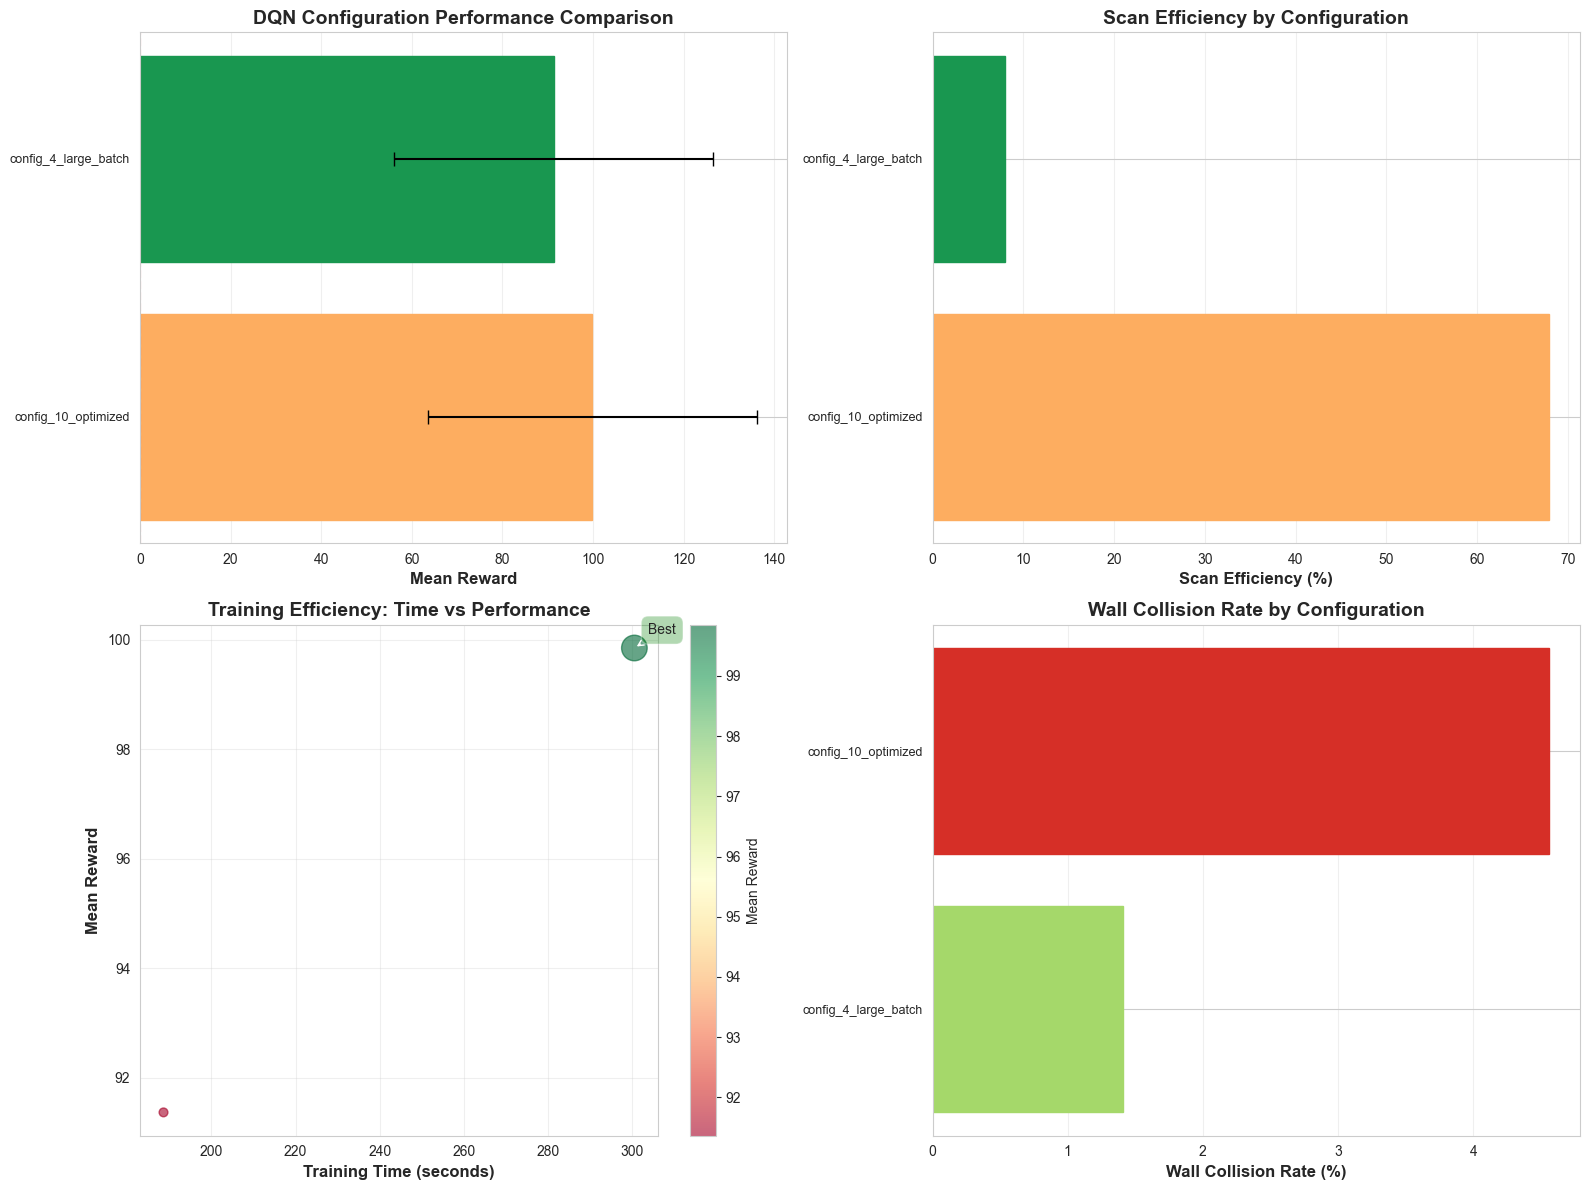

In [9]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 9: Visualize Results - Comparison Plot
# ═══════════════════════════════════════════════════════════════════════
"""
Create comprehensive visualization of results (matching PPO format)
"""

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Sort by mean reward
results_sorted = results_df.sort_values('mean_reward', ascending=False)

# 1. Mean Reward Comparison
ax1 = axes[0, 0]
bars = ax1.barh(range(len(results_sorted)), results_sorted['mean_reward'], 
                xerr=results_sorted['std_reward'], capsize=5)
ax1.set_yticks(range(len(results_sorted)))
ax1.set_yticklabels(results_sorted['config_name'], fontsize=9)
ax1.set_xlabel('Mean Reward', fontsize=12, fontweight='bold')
ax1.set_title('DQN Configuration Performance Comparison', fontsize=14, fontweight='bold')
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.5)

# Color bars by performance
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(bars)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

ax1.grid(axis='x', alpha=0.3)

# 2. Scan Efficiency (matching PPO)
ax2 = axes[0, 1]
scan_eff_sorted = results_df.sort_values('scan_efficiency', ascending=False)
bars2 = ax2.barh(range(len(scan_eff_sorted)), scan_eff_sorted['scan_efficiency'] * 100)
ax2.set_yticks(range(len(scan_eff_sorted)))
ax2.set_yticklabels(scan_eff_sorted['config_name'], fontsize=9)
ax2.set_xlabel('Scan Efficiency (%)', fontsize=12, fontweight='bold')
ax2.set_title('Scan Efficiency by Configuration', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Color bars
colors2 = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(bars2)))
for bar, color in zip(bars2, colors2):
    bar.set_color(color)

# 3. Training Time vs Performance
ax3 = axes[1, 0]
scatter = ax3.scatter(results_df['training_time'], results_df['mean_reward'], 
                     s=results_df['scan_efficiency']*500, alpha=0.6, 
                     c=results_df['mean_reward'], cmap='RdYlGn')
ax3.set_xlabel('Training Time (seconds)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Mean Reward', fontsize=12, fontweight='bold')
ax3.set_title('Training Efficiency: Time vs Performance', fontsize=14, fontweight='bold')
ax3.grid(alpha=0.3)

# Add labels for best and worst
best_idx = results_df['mean_reward'].idxmax()
worst_idx = results_df['mean_reward'].idxmin()
ax3.annotate('Best', xy=(results_df.loc[best_idx, 'training_time'], 
                         results_df.loc[best_idx, 'mean_reward']),
            xytext=(10, 10), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='green', alpha=0.3),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Colorbar
plt.colorbar(scatter, ax=ax3, label='Mean Reward')

# 4. Wall Collision Rate (matching PPO)
ax4 = axes[1, 1]
wall_coll_sorted = results_df.sort_values('wall_collision_rate', ascending=True)
bars4 = ax4.barh(range(len(wall_coll_sorted)), wall_coll_sorted['wall_collision_rate'] * 100)
ax4.set_yticks(range(len(wall_coll_sorted)))
ax4.set_yticklabels(wall_coll_sorted['config_name'], fontsize=9)
ax4.set_xlabel('Wall Collision Rate (%)', fontsize=12, fontweight='bold')
ax4.set_title('Wall Collision Rate by Configuration', fontsize=14, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

# Color bars (lower is better, so reverse colors)
colors4 = plt.cm.RdYlGn_r(np.linspace(0.3, 0.9, len(bars4)))
for bar, color in zip(bars4, colors4):
    bar.set_color(color)

plt.tight_layout()
plot_path = plots_dir / "dqn_comparison.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Comparison plot saved to {plot_path}")
plt.show()

In [10]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 10: Detailed Analysis - Top 3 Configurations
# ═══════════════════════════════════════════════════════════════════════
"""
Detailed analysis of top 3 performing configurations (matching PPO format)
"""

print("\n" + "="*70)
print("TOP 3 CONFIGURATIONS - DETAILED ANALYSIS")
print("="*70)

top3 = results_df.nlargest(3, 'mean_reward')

for idx, (_, config) in enumerate(top3.iterrows(), 1):
    print(f"\n{'─'*70}")
    print(f"#{idx}: {config['config_name']}")
    print(f"{'─'*70}")
    print(f"Description: {config['description']}")
    print(f"Mean Reward: {config['mean_reward']:.2f} ± {config['std_reward']:.2f}")
    print(f"Avg Episode Length: {config['avg_episode_length']:.1f} steps")
    print(f"Wall Collision Rate: {config['wall_collision_rate']:.2%}")
    print(f"Scan Efficiency: {config['scan_efficiency']:.2%}")
    print(f"Avg Pickup Attempts: {config['avg_pickup_attempts']:.2f}")
    if config['avg_time_to_find_survivor'] is not None:
        print(f"Avg Time to Find Survivor: {config['avg_time_to_find_survivor']:.1f} steps")
    print(f"Survivor Found Count: {config['survivor_found_count']}/100")
    print(f"Training Time: {config['training_time']:.1f} seconds")
    
    if 'hyperparameters' in config and config['hyperparameters']:
        print(f"\nKey Hyperparameters:")
        hparams = config['hyperparameters']
        print(f"  - Learning Rate: {hparams.get('learning_rate', 'N/A')}")
        print(f"  - Batch Size: {hparams.get('batch_size', 'N/A')}")
        print(f"  - Buffer Size: {hparams.get('buffer_size', 'N/A')}")
        print(f"  - Gamma: {hparams.get('gamma', 'N/A')}")
        print(f"  - Exploration Fraction: {hparams.get('exploration_fraction', 'N/A')}")


TOP 3 CONFIGURATIONS - DETAILED ANALYSIS

──────────────────────────────────────────────────────────────────────
#1: config_10_optimized
──────────────────────────────────────────────────────────────────────
Description: Optimized - Well-balanced settings
Mean Reward: 99.85 ± 36.24
Avg Episode Length: 173.9 steps
Wall Collision Rate: 4.56%
Scan Efficiency: 67.93%
Avg Pickup Attempts: 0.70
Avg Time to Find Survivor: 15.5 steps
Survivor Found Count: 62/100
Training Time: 300.5 seconds

Key Hyperparameters:
  - Learning Rate: 0.0003
  - Batch Size: 64
  - Buffer Size: 50000
  - Gamma: 0.99
  - Exploration Fraction: 0.3

──────────────────────────────────────────────────────────────────────
#2: config_4_large_batch
──────────────────────────────────────────────────────────────────────
Description: Large Batch - Stable gradients
Mean Reward: 91.37 ± 35.21
Avg Episode Length: 68.9 steps
Wall Collision Rate: 1.41%
Scan Efficiency: 8.00%
Avg Pickup Attempts: 1.64
Avg Time to Find Survivor: 16

In [11]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 11: Export Summary for Report
# ═══════════════════════════════════════════════════════════════════════
"""
Create summary tables and statistics for the final report (matching PPO format)
"""

# Summary statistics
summary = {
    'total_configs': len(all_results),
    'best_config': best_config['config_name'],
    'best_mean_reward': float(best_config['mean_reward']),
    'best_scan_efficiency': float(best_config['scan_efficiency']),
    'best_wall_collision_rate': float(best_config['wall_collision_rate']),
    'avg_mean_reward': float(results_df['mean_reward'].mean()),
    'std_mean_reward': float(results_df['mean_reward'].std()),
    'avg_scan_efficiency': float(results_df['scan_efficiency'].mean()),
    'avg_wall_collision_rate': float(results_df['wall_collision_rate'].mean()),
    'total_training_time': float(results_df['training_time'].sum()),
}

# Save summary
summary_path = results_dir / "dqn_summary.json"
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=4)

print("\n" + "="*70)
print("DQN TRAINING SUMMARY")
print("="*70)
for key, value in summary.items():
    if 'rate' in key or 'efficiency' in key:
        if isinstance(value, float) and value < 1:
            print(f"{key.replace('_', ' ').title()}: {value:.2%}")
        else:
            print(f"{key.replace('_', ' ').title()}: {value}")
    else:
        print(f"{key.replace('_', ' ').title()}: {value}")

print(f"\n✓ Summary saved to {summary_path}")


DQN TRAINING SUMMARY
Total Configs: 2
Best Config: config_10_optimized
Best Mean Reward: 99.84809999999997
Best Scan Efficiency: 67.93%
Best Wall Collision Rate: 4.56%
Avg Mean Reward: 95.60709999999999
Std Mean Reward: 5.997679718024275
Avg Scan Efficiency: 37.96%
Avg Wall Collision Rate: 2.99%
Total Training Time: 489.124377

✓ Summary saved to c:\Users\HP\Programming\ML\fire_rescue_agent\results\dqn_summary.json
